# Full DL Network

In [3]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Data location
data_location = '/Users/philsamoei/projects/ML/udacity/scholarshipchallenge/deep-learning-v2-pytorch/data/F_MNIST_data/'


### Grab data

In [4]:
# Define transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#Download and load the training data
trainset = datasets.FashionMNIST(data_location, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)

# Download and load validation data
testset = datasets.FashionMNIST(data_location, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Build the model

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Flatten the incoming tensor
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

### Train & Validate

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    current_training_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        current_training_loss+=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape) 
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(current_training_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(current_training_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

Epoch: 1/30..  Training Loss: 0.536..  Test Loss: 0.448..  Test Accuracy: 0.843
Epoch: 2/30..  Training Loss: 0.407..  Test Loss: 0.409..  Test Accuracy: 0.856
Epoch: 3/30..  Training Loss: 0.368..  Test Loss: 0.405..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.343..  Test Loss: 0.375..  Test Accuracy: 0.861
Epoch: 5/30..  Training Loss: 0.323..  Test Loss: 0.403..  Test Accuracy: 0.858
Epoch: 6/30..  Training Loss: 0.309..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 7/30..  Training Loss: 0.299..  Test Loss: 0.378..  Test Accuracy: 0.865
Epoch: 8/30..  Training Loss: 0.289..  Test Loss: 0.383..  Test Accuracy: 0.872
Epoch: 9/30..  Training Loss: 0.279..  Test Loss: 0.405..  Test Accuracy: 0.862
Epoch: 10/30..  Training Loss: 0.276..  Test Loss: 0.377..  Test Accuracy: 0.875
Epoch: 11/30..  Training Loss: 0.274..  Test Loss: 0.361..  Test Accuracy: 0.879
Epoch: 12/30..  Training Loss: 0.257..  Test Loss: 0.380..  Test Accuracy: 0.875
Epoch: 13/30..  Training Loss: 0.252.

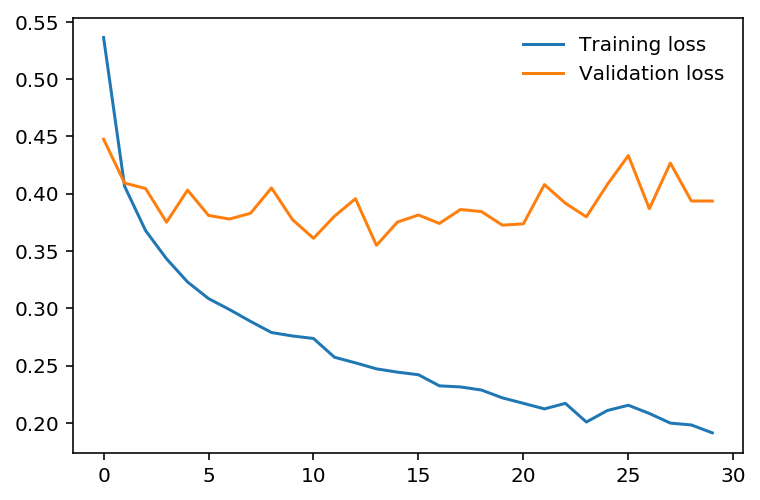

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Same model with dropout to improve on overfitting

In [16]:
class DropoutClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
        # Dropout 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #Flatten the image
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.layer1(x)))
        x = self.dropout(F.relu(self.layer2(x)))
        x = self.dropout(F.relu(self.layer3(x)))
        x = F.log_softmax(self.layer4(x), dim=1)
        
        return x

In [20]:
model = DropoutClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # training loop
        optimizer.zero_grad()
        
        ps_logs = model(images)
        loss = criterion(ps_logs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        # validation loop
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                # Do a forward pass on the testing data
                logs_ps = model(images)
                
                # Get the test loss
                test_loss += criterion(logs_ps, labels)
                
                # Convert the logs probabilities to probabilities
                ps = torch.exp(logs_ps)
                
                # Get the predicted class from the probabilities 
                top_p, top_class = ps.topk(1, dim=1)
                
                # Compare the the predicted class with the true labels
                equals = top_class == labels.view(*top_class.shape)
                
                # calculate the accuracy
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Set the model back to training mode for the next epoch
        model.train()
        
        # print summary statistics for each epoch
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(trainloader))
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(train_losses[-1]),
              "Test loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}..".format(accuracy/len(testloader))
             )

Epoch: 1/30.. Training loss: 0.606.. Test loss: 0.082.. Test Accuracy: 0.819..
Epoch: 2/30.. Training loss: 0.478.. Test loss: 0.073.. Test Accuracy: 0.835..
Epoch: 3/30.. Training loss: 0.448.. Test loss: 0.070.. Test Accuracy: 0.855..
Epoch: 4/30.. Training loss: 0.432.. Test loss: 0.069.. Test Accuracy: 0.852..
Epoch: 5/30.. Training loss: 0.418.. Test loss: 0.070.. Test Accuracy: 0.857..
Epoch: 6/30.. Training loss: 0.409.. Test loss: 0.066.. Test Accuracy: 0.857..
Epoch: 7/30.. Training loss: 0.404.. Test loss: 0.068.. Test Accuracy: 0.860..
Epoch: 8/30.. Training loss: 0.400.. Test loss: 0.063.. Test Accuracy: 0.865..
Epoch: 9/30.. Training loss: 0.393.. Test loss: 0.063.. Test Accuracy: 0.866..
Epoch: 10/30.. Training loss: 0.384.. Test loss: 0.066.. Test Accuracy: 0.861..
Epoch: 11/30.. Training loss: 0.382.. Test loss: 0.065.. Test Accuracy: 0.860..
Epoch: 12/30.. Training loss: 0.378.. Test loss: 0.062.. Test Accuracy: 0.868..
Epoch: 13/30.. Training loss: 0.379.. Test loss: 

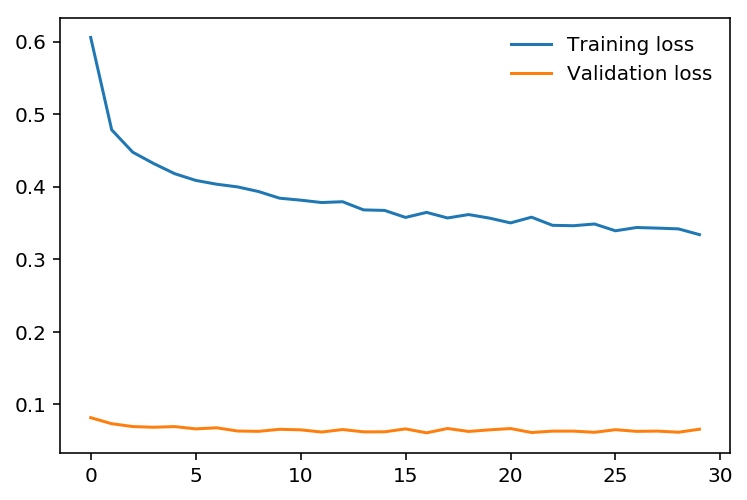

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Inference 

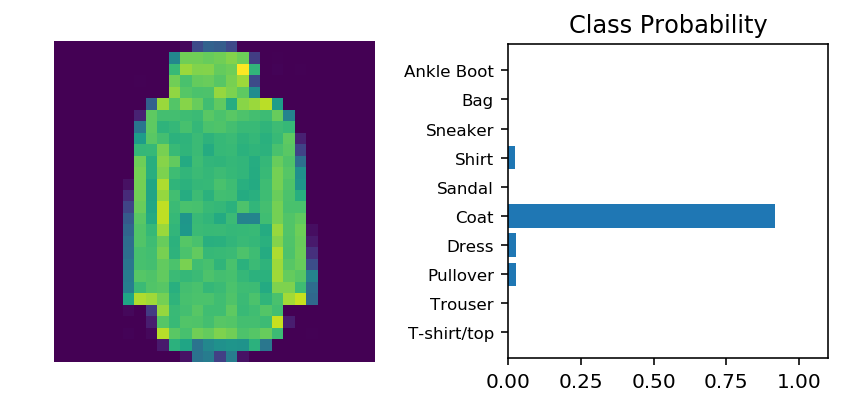

In [22]:
import helperper

model.eval()

dataiter = ititer(testloader)

images, labels = dataiter.next()

img = images[0]

img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)
    
torch= torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')